# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/rubrics/2322/view).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

## / Prepare
### // load env and data

In [1]:
# import data
## import basic libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from pprint import pprint

## import ml libs

## import specific func
import project_tests as t

## set warnings
import warnings
warnings.simplefilter('ignore')

## set paras
%matplotlib inline

In [2]:
# load data
df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# snip data
display(df.head(1))
display(df_content.head(1))
df.shape, df_content.shape

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7


,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0


((45993, 3), (1056, 5))

### // alter data types
- id liked should be str type

In [3]:
# change id liked column to str
df.article_id = df.article_id.astype(int).astype(str)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45993 entries, 0 to 45992
Data columns (total 3 columns):
article_id    45993 non-null object
title         45993 non-null object
email         45976 non-null object
dtypes: object(3)
memory usage: 1.1+ MB


### // check detail on str column

In [4]:
# check more detail on str column
## check1
#pprint(df_content.doc_body[0])

In [5]:
## check2
pprint(df_content.doc_description[0])
pprint(df_content.doc_full_name[0])
pprint(df.title[0])

'Detect bad readings in real time using Python and Streaming Analytics.'
'Detect Malfunctioning IoT Sensors with Streaming Analytics'
('using pixiedust for fast, flexible, and easier data analysis and '
 'experimentation')


## <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

In [6]:
## pre - del na
print(df.shape[0])
df.dropna(inplace=True)
df.shape[0]

45993


45976

In [7]:
## 1a user - article iteration times
df.article_id.shape[0]

45976

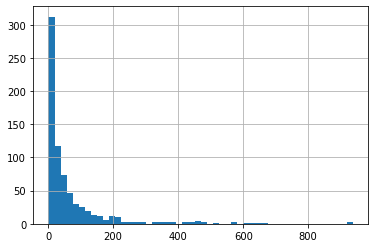

In [8]:
## 1b hist for article usage
pd.Series.hist(df.article_id.value_counts(),bins=50);

In [9]:
## 1c max useage (by user)
## -updated 
article_byuser = df.groupby('email')['article_id'].count()
article_byuser.max()
## arc for only for max useage by article
#df.article_id.value_counts()[0]

364

In [10]:
## 1d median of article usage
#df.article_id.value_counts().median()
## -updated- should groupby on user (email)
df.groupby('email')['article_id'].count().median()

3.0

In [11]:
# Fill in the median and maximum number of user_article interactios below

median_val = 3 # 50% of individuals interact with ____ number of articles or fewer.
max_views_by_user = 364 # The maximum number of user-article interactions by any 1 user is ______.

`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [12]:
# delete duplicates
## compare unique and numbers
df_content.doc_full_name.nunique(), df_content.shape[0]

(1051, 1056)

In [13]:
# Find and explore duplicate articles
df_content[df.duplicated(['article_id'])]

,doc_body,doc_description,doc_full_name,doc_status,article_id
6,UPGRADING YOUR POSTGRESQL TO 9.5Share on Twitt...,Upgrading your PostgreSQL deployment to versio...,Upgrading your PostgreSQL to 9.5,Live,6
8,* Host\r\n * Competitions\r\n * Datasets\r\n *...,Kaggle is your home for data science. Learn ne...,Data Science Bowl 2017,Live,8
13,Maureen McElaney Blocked Unblock Follow Follow...,There’s a reason you’ve been hearing a lot abo...,Bridging the Gap Between Python and Scala Jupy...,Live,13
17,Enterprise Pricing Articles Sign in Free 30-Da...,We've always considered MySQL as a potential C...,Compose for MySQL now for you,Live,17
18,Homepage Follow Sign in / Sign up * Home\r\n *...,It has never been easier to build AI or machin...,The Greatest Public Datasets for AI – Startup ...,Live,18
20,Homepage Follow Sign in / Sign up Homepage * H...,It is often useful to use RStudio for one piec...,Working interactively with RStudio and noteboo...,Live,20
21,Raj Singh Blocked Unblock Follow Following Dev...,You’re doing your data a disservice if you don...,Mapping for Data Science with PixieDust and Ma...,Live,21
24,THE CONVERSATIONAL INTERFACE IS THE NEW PARADI...,Botkit provides a simple framework to handle t...,The Conversational Interface is the New Paradigm,Live,24
26,GOOGLE RESEARCH BLOG The latest news from Rese...,Much of driving is spent either stuck in traff...,Using Machine Learning to predict parking diff...,Live,26
27,Skip navigation Upload Sign in SearchLoading.....,This talk assumes you have a basic understandi...,Getting The Best Performance With PySpark,Live,27


In [14]:
# Remove any rows that have the same article_id - only keep the first
print(df_content.shape)
df_content.drop_duplicates(subset = 'article_id', inplace=True)
print(df_content.shape)

(1056, 5)
(1051, 5)


`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [15]:
# a
series = df.article_id.value_counts()
len(series[series == 1]), len(series[series >= 1]), series.shape[0]

(18, 714, 714)

In [16]:
# b
df.article_id.nunique()

714

In [17]:
#c
## drop na already done at the beginning (17 null at email)
df.email.nunique()

5148

In [18]:
#d solution, df.shape
## 剔除 email 为空的, 再对 article_id 进行value count 求和
## 实际上只有 email 有17个空值
## s1
df.article_id.value_counts().sum()
## 开始傻掉了,这里就应该是去除空值之后的行数(每行代表一次互动)
## s2
df.shape[0], df.email.shape[0]

(45976, 45976)

In [19]:
unique_articles = 714 # The number of unique articles that have at least one interaction
total_articles = 1051 # The number of unique articles on the IBM platform
unique_users = 5148 # The number of unique users
user_article_interactions = 45993 # The number of user-article interactions

`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [20]:
email_series = df.article_id.value_counts()
email_series.index[0], email_series[0]

('1429', 937)

In [21]:
most_viewed_article_id = '1429.0' # The most viewed article in the dataset as a string with one value following the decimal 
max_views = 937 # The most viewed article in the dataset was viewed how many times?

In [22]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430,"using pixiedust for fast, flexible, and easier...",1
1,1314,healthcare python streaming application demo,2
2,1429,use deep learning for image classification,3
3,1338,ml optimization using cognitive assistant,4
4,1276,deploy your python model as a restful api,5


In [23]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

# Warning! 
## 一些值是在非清理na和重复时候得出的, 具体更新过程写在了前面代码框中了

It looks like you have everything right here! Nice job!


## <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [24]:
# testing bloc
# identicle with Part I
top_articles_id = df.article_id.value_counts().index[:10]
print(top_articles_id)
list(df.iloc[top_articles_id]['title'].str.title())

Index(['1429', '1330', '1431', '1427', '1364', '1314', '1293', '1170', '1162',
       '1304'],
      dtype='object')


['10 Tips On Using Jupyter Notebook',
 'Working With Notebooks In Dsx',
 'Times World University Ranking Analysis',
 'Rapidly Build Machine Learning Flows With Dsx',
 'Jupyter Notebook Tutorial',
 'Deep Learning From Scratch I: Computational Graphs',
 'Analyze Accident Reports On Amazon Emr Spark',
 'Ml Optimization Using Cognitive Assistant',
 'Apache Spark Lab, Part 2: Querying Data',
 'Putting A Human Face On Machine Learning']

In [25]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # Your code here
    top_articles_id = df.article_id.value_counts().index[:n]
    ## assert need unchaged title
    #top_articles = list(df.iloc[top_articles_id]['title'].str.title())
    #top_articles = list(df.iloc[top_articles_id]['title'])
    ## upper code give a diff result, later figure out why it happens
    top_articles = df[df['article_id'].isin(top_articles_id)]['title'].unique().tolist()
    
    return top_articles # Return the top article titles from df (not df_content)

# strange funtion, repeate of the upper one
def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles' id
    
    '''
    # Your code here
    # top_articles_id = df.article_id.value_counts().index[:n]
    top_articles_id = df.article_id.value_counts().index[:n].tolist()
    
    return top_articles_id # Return the top article ids

In [26]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['healthcare python streaming application demo', 'use deep learning for image classification', 'apache spark lab, part 1: basic concepts', 'predicting churn with the spss random tree algorithm', 'analyze energy consumption in buildings', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'gosales transactions for logistic regression model', 'insights from new york car accident reports', 'finding optimal locations of new store using decision optimization']
['1429', '1330', '1431', '1427', '1364', '1314', '1293', '1170', '1162', '1304']


In [27]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


## <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [28]:
# df reload
## for template do not cleaning enough
df = pd.read_csv('data/user-item-interactions.csv')
del df['Unnamed: 0']

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [29]:
# test code
display(df.groupby(['user_id','article_id']).count())
display(df.groupby(['user_id','article_id'])['title'].count().unstack())
# maybe get_dummies is more efficient, test later

title
user_id article_id       
1       43.0            1
        109.0           1
        151.0           1
        268.0           1
        310.0           2
...                   ...
5146    1394.0          1
        1416.0          1
5147    233.0           1
5148    1160.0          1
5149    16.0            1

[33682 rows x 1 columns]

article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,...,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    # Fill in the function here
    df_temp = df.copy()
    user_item = df_temp.groupby(['user_id','article_id'])['title'].count().unstack()
    
    user_item.fillna(0, inplace=True)
    
    return user_item # return the user_item matrix 

In [32]:
user_item = create_user_item_matrix(df)
user_item.head()

article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [34]:
# I can only get 47 for last questions
user_item.shape, user_item.drop_duplicates().shape, user_item.sum(axis=1)[1], user_item.drop_duplicates().sum(axis=1)[1]

((5149, 714), (4048, 714), 47.0, 47.0)

### /Question1/ 
I can not run through this test last question, need instructions, thanks!
- my value is 47
- assert want 36
- solution code are above

In [35]:
# for pass the code make 3rd assert as note

## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
#assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [37]:
def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    # Fill in the function here
    df_copy = df.drop_duplicates(subset=['article_id','user_id'])
    
    user_item = df_copy.groupby(['user_id','article_id'])['title'].count().unstack()
    
    user_item.fillna(0, inplace=True)
    
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)
user_item.head(1)

article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [38]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    '''

    # get user index
    user_index = list(user_item.index.values)
    #user_index = df.user_id.unique()
    
    # get user data
    ## user_item_value = np.array(user_item.iloc[user_id,:])
    ## upper code shape not matchprint(user_item_value)
    user_item_value = np.array(user_item[user_item.index==user_id])

    # dot product
    dot_product = np.dot(user_item_value, np.array(user_item).T)[0]
    dot_product = pd.Series(dot_product, index=user_index)
    
    # remove id
    dot_product.drop(labels=[user_id], inplace=True)

    # sorting
    dot_product = dot_product.sort_values(ascending=False)
   
    # generate list
    most_similar_users = dot_product.index.values.tolist()
       
    return most_similar_users # return a list of the users in order from most to least similar

In [39]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 3870, 131, 4201, 46, 3697]
The 5 most similar users to user 3933 are: [1, 3782, 23, 203, 4459]
The 3 most similar users to user 46 are: [4201, 3782, 23]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [40]:
# test code
article_ids = find_similar_users(1)[:10]
df.iloc[article_ids,:]['title'].str.title()

3933      Brunel: Imitation Is A Sincere Form Of Flattery
23      Access Db2 Warehouse On Cloud And Db2 With Python
3782          Airbnb Data For Analytics: Toronto Calendar
203     10 Must Attend Data Science, Ml And Ai Confere...
4459    Finding Optimal Locations Of New Store Using D...
3870    Why You Should Master R (Even If It Might Even...
131              Data Visualization With R: Scrum Metrics
4201         Healthcare Python Streaming Application Demo
46                               Uci: Sms Spam Collection
3697          Flexdashboard: Interactive Dashboards For R
Name: title, dtype: object

In [41]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    ## assert require not change title
    #article_names = list(df.iloc[article_id,:]['title'].str.title())
    
    # get article index to list type float
    article_index = list(map(float, article_ids))
    
    # rearrange df by index
    df_new = df.drop_duplicates(subset='article_id')[['article_id', 'title']].set_index('article_id')
    
    # get article name
    article_names_ori = df_new.loc[article_index]['title'].values.tolist()
    
    # to remove str
    article_names = []
    for name in article_names_ori:
        try:
            name = name.replace("\nName: title, dtype: object", "")
        except:
            continue
        article_names.append(name)
    
    ## archive
    #article_ids = article_index.index[name_index].values.tolist()
    #article_names = list(df.iloc[article_ids,:]['title'])
    
    return article_names # Return the article names associated with list of article ids

In [42]:
# -> get_article_names

def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    
    # select user series
    # 选中给定 id 的数据
    user_series = user_item.loc[user_id]
    
    # extract user article index
    # 检查数据观察那些文章交互过（文章的index）
    name_index = np.where(user_series == 1)
    
    # match index to value (be attention also is int like), convert to list
    # 对应上文章的编号（value）
    article_ids = user_series.index[name_index].values.tolist()
    
    # get article name on article_ids
    # 根据文章编号寻找名字
    article_names = get_article_names(article_ids)
    
    return article_ids, article_names # return the ids and names

In [43]:
# -> find_similar_users
# -> get_user_articles

def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    ## create list
    recs= []
    
    ## get similar user (take m user for m output for less compute)
    similar_user = find_similar_users(user_id)
    #similar_user = find_similar_users(user_id)[:m]
    
    for user in similar_user:
        ## get similar user's article
        simi_index, simi_name = get_user_articles(user)
        
        ## get user's seen article
        seen_index, seen_name = get_user_articles(user_id)
        
        ## similar minus seen
        select_index = np.setdiff1d(np.array(simi_index),np.array(seen_index), assume_unique=True)
        
        ## write data
        recs.extend(select_index.tolist())
        
        ## break if enough
        if len(recs) >= m:
            break
    
    # change int to str
    #recs = list(map(str, recs))
    
    return recs[:m] # return your recommendations for this user_id    

In [45]:
# Check Results
display(user_user_recs(1, 10))
get_article_names(user_user_recs(1, 3)) # Return 10 recommendations for user 1

[2.0, 12.0, 14.0, 16.0, 26.0, 28.0, 29.0, 33.0, 50.0, 74.0]

['this week in data science (april 18, 2017)',
 'timeseries data analysis of iot events by using jupyter notebook',
 'got zip code data? prep it for analytics. – ibm watson data lab – medium']

In [46]:
# test code
## both int and str are acceptable
display(get_article_names(['1320.0', '232.0', '844.0']))
display(get_article_names([1320.0, 232.0, 844.0]))

['housing (2015): united states demographic measures',
 'self-service data preparation with ibm data refinery',
 'use the cloudant-spark connector in python notebook']

['housing (2015): united states demographic measures',
 'self-service data preparation with ibm data refinery',
 'use the cloudant-spark connector in python notebook']

In [51]:
# Test your functions here - No need to change this code - just run this cell

## I change it bit for str input in list not pass
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
#assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[0]) == set([1320.0, 232.0, 844.0])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
#assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[0]) == set([1024.0, 1176.0, 1305.0, 1314.0, 1422.0, 1427.0])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [52]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    ## get user index
    user_index = list(user_item.index.values)
    #user_index = df.user_id.unique()
    
    ## get user data
    #user_item_value = np.array(user_item.iloc[user_id,:])
    #upper code shape not matchprint(user_item_value)
    user_item_value = np.array(user_item[user_item.index==user_id])

    ## dot product
    dot_product = np.dot(user_item_value, np.array(user_item).T)[0]
    dot_product = pd.Series(dot_product, index=user_index)
    
    ## count interact
    interact_df = df.groupby(['user_id'])['article_id'].count()
    interact_count = interact_df.loc[user_index]
    
    neighbors_df = pd.DataFrame({'neighbor_id':user_index,\
                                 'simi':dot_product,\
                                 'interact_count':interact_count}).set_index('neighbor_id')
    
    ## remove current user from dataframe
    neighbors_df.drop([user_id], inplace=True)
    
    ## sort by similarity and then by number of interactions
    neighbors_df.sort_values(['simi', 'interact_count'], ascending=[False, False], inplace=True)
    
    return neighbors_df # Return the dataframe specified in the doc_string

In [53]:
def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    ## create list
    recs= []
    
    ## get similar user (take m user for m output for less compute)
    top_user = get_top_sorted_users(user_id)
    user_index = top_user.index.values
    
    ## rank articles on interact
    article_rank = df.groupby(['article_id'])['user_id'].count()
    
    for user in user_index:
        ## get similar user's article
        simi_index, simi_name = get_user_articles(user)
        
        ## get user's seen article
        seen_index, seen_name = get_user_articles(user_id)
        
        ## similar minus seen
        select_index = np.setdiff1d(np.array(simi_index),np.array(seen_index), assume_unique=True)
        
        ## sort recommended articles by amount of interaction
        sorted_article = article_rank.loc[select_index].sort_values(ascending=False).index.values.tolist()
        
        ## write data
        recs.extend(sorted_article)
        
        ## break if enough
        if len(recs) >= m:
            break
            
    ## get output
    recs = recs[:m]
    
    rec_names = get_article_names(recs)
    
    return recs, rec_names

In [54]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
[1330.0, 1427.0, 1364.0, 1170.0, 1162.0, 1304.0, 1351.0, 1160.0, 1354.0, 1368.0]

The top 10 recommendations for user 20 are the following article names:
['insights from new york car accident reports', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model', 'model bike sharing data with spss', 'analyze accident reports on amazon emr spark', 'movie recommender system with spark machine learning', 'putting a human face on machine learning']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [55]:
# check answers
display(get_top_sorted_users(1).head())
#display(get_top_sorted_users(131).iloc[10,:])
display(get_top_sorted_users(131).head(10))

,simi,interact_count
neighbor_id,,
3933,35.0,45
23,17.0,364
3782,17.0,363
203,15.0,160
4459,15.0,158


,simi,interact_count
neighbor_id,,
3870,74.0,144
3782,39.0,363
23,38.0,364
203,33.0,160
4459,33.0,158
98,29.0,170
3764,29.0,169
49,29.0,147
3697,29.0,145


In [56]:
### Tests with a dictionary of results

user1_most_sim = 3933 # Find the user that is most similar to user 1 
user131_10th_sim = 242 # Find the 10th most similar user to user 131

In [57]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

**Provide your response here.**

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [58]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = new_user_recs = get_top_article_ids(10) # Your recommendations here
new_user_recs

['1429',
 '1330',
 '1431',
 '1427',
 '1364',
 '1314',
 '1293',
 '1170',
 '1162',
 '1304']

### /Question2/ 
I can not run through this test last question, need instructions, thanks!
- my value is 1429(first)
- assert want 1314(first)
- solution code are above

In [61]:
# dec assert for code runing
# assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


- may finish next vertion

## <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations (EXTRA - NOT REQUIRED)</a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term.  You might consider content to be the **doc_body**, **doc_description**, or **doc_full_name**.  There isn't one way to create a content based recommendation, especially considering that each of these columns hold content related information.  

`1.` Use the function body below to create a content based recommender.  Since there isn't one right answer for this recommendation tactic, no test functions are provided.  Feel free to change the function inputs if you decide you want to try a method that requires more input values.  The input values are currently set with one idea in mind that you may use to make content based recommendations.  One additional idea is that you might want to choose the most popular recommendations that meet your 'content criteria', but again, there is a lot of flexibility in how you might make these recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [62]:
def make_content_recs():
    '''
    INPUT:
    
    OUTPUT:
    
    '''

`2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function?  Is there anything novel about your content based recommender?

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

**Write an explanation of your content based recommendation system here.**

`3.` Use your content-recommendation system to make recommendations for the below scenarios based on the comments.  Again no tests are provided here, because there isn't one right answer that could be used to find these content based recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [63]:
# make recommendations for a brand new user


# make a recommendations for a user who only has interacted with article id '1427.0'



## <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [64]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [65]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [66]:
# Perform SVD on the User-Item Matrix Here

u, s, vt = # use the built in to get the three matrices

SyntaxError: invalid syntax (<ipython-input-66-d4217e3461db>, line 3)

**Provide your response here.**

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

In [67]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

NameError: name 's' is not defined

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [68]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    # Your code here
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

NameError: name 'user_item_train' is not defined

In [69]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': # letter here, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': # letter here, 
    'How many articles can we make predictions for in the test set?': # letter here,
    'How many articles in the test set are we not able to make predictions for because of the cold start problem?': # letter here
}

t.sol_4_test(sol_4_dict)

SyntaxError: invalid syntax (<ipython-input-69-09c852d62ee5>, line 10)

`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [70]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = # fit svd similar to above then use the cells below

SyntaxError: invalid syntax (<ipython-input-70-f93e4efee773>, line 2)

In [71]:
# Use these cells to see how well you can use the training 
# decomposition to predict on test data

`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

**Your response here.**

<a id='conclusions'></a>
### Extras
Using your workbook, you could now save your recommendations for each user, develop a class to make new predictions and update your results, and make a flask app to deploy your results.  These tasks are beyond what is required for this project.  However, from what you learned in the lessons, you certainly capable of taking these tasks on to improve upon your work here!


## Conclusion

> Congratulations!  You have reached the end of the Recommendations with IBM project! 

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the [rubric](https://review.udacity.com/#!/rubrics/2322/view). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations! 

In [72]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])

0